In [1]:
import pickle
import numpy as np
import seaborn as sns
from collections import Counter

In [2]:
entities_names = pickle.load(open("all_indivs.pickle", 'rb'))


with open('all_indivs.txt', 'w') as f:
    for line in entities_names:
        f.write(f"{line}\n")
        
# remove one word entity
# sub any non-alphanum-character w/ ""


entities_alphnum_only = ["".join(char.lower() for char in entity_name if char.isalnum() or char == " ") 
                         for entity_name in entities_names
                        if len(entity_name.split()) > 1]
entities_gt1_word = [e for e in entities_names if len(e.split()) > 1]

In [3]:
len(entities_names)

33020

In [4]:
all_edit_dist = np.load("edit_distance_result.npy")

In [5]:
unique_values, value_counts = np.unique(all_edit_dist, return_counts=True)

print("Unique Values:", unique_values)
print("Value Counts:", value_counts)

Unique Values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
Value Counts: [    33543      2722      7836     54879    274999   1117823   4340739
  15083501  41629791  88278286 143012287 180706359 180836560 147080331
  99790765  59382553  32897372  18081512   9952919   5530972   3048799
   1640750    877209    492068    300599    183108     97207     47821
     25662     14604      8548      4613      2545      1604      1120
       783       545       355       244       198       127        83
        60        47        22        21        11        14        17
         6         7         3         5         2         4         1]


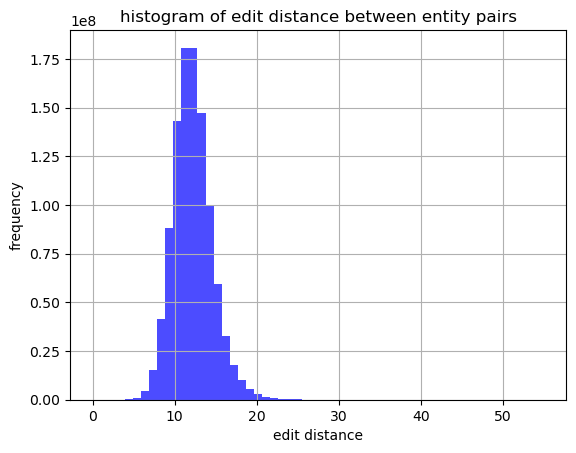

In [15]:
import matplotlib.pyplot as plt

# Assuming you have unique_values and value_counts from your previous code

plt.hist(unique_values, bins=len(unique_values), weights=value_counts, color='blue', alpha=0.7)
plt.xlabel('edit distance')
plt.ylabel('frequency')
plt.title('histogram of edit distance between entity pairs')
plt.grid(True)
plt.show()

In [8]:
ct = 0
cases = Counter()
casesPairs = {}
pairing_dict = {} # keep tracks of pairing to obtain an unique key


for i in range(len(all_edit_dist)):
    
    if (np.sort(all_edit_dist[i])[1] <=1 ):
        query_string = entities_alphnum_only[i].strip()
        query_words = query_string.split()
        
        # for now let's skip names that only composed of one word
        if (len(query_words) == 1):
            continue
        
        match_order = 0
        sorted_arg = np.argsort(all_edit_dist[i])
        sorted_match = np.sort(all_edit_dist[i])
        
        ct_col = 0
        dup_ct = -1 # start with -1 because there's at least 1 self match
        while (sorted_match[ct_col] <= 1 ):
            flags = ""
            cflags = ""
            ct_flag = 0;
            
            target_string = entities_alphnum_only[sorted_arg[ct_col]].strip()
            proper_val = sorted_match[ct_col]
            ct_col += 1
            
            ## case: exact duplicated
            target_words = target_string.split()
            
            n_add_words = abs(len(entities_alphnum_only[i].split())-len(target_string.split()))
            
            if n_add_words == 0 and proper_val == 0 and len(entities_alphnum_only[i]) == len(target_string):
                if (dup_ct == -1):
                    dup_ct += 1
                    continue
            
            pairing_str = "\t".join(sorted([entities_gt1_word[i],
                                            entities_gt1_word[sorted_arg[ct_col-1]]]))
            if pairing_str in pairing_dict:
                continue
            
            if n_add_words == 0:
                if ct_flag > 0: 
                    cases["No extra word;"] += 1
                flags += "No extra word;"
                cases[flags] += 1
                if proper_val == 0:
                    if len(entities_alphnum_only[i]) == len(target_string):
                        cases["dup;"] += 1
                        flags += "dup;"
                        cases[flags] += 1
                if proper_val == 1:
                    cflags = "extra_word_0_char_typo_1"
                    if len(query_string) == len(target_string):
                        cases["1 char typo (sub);"] += 1
                        flags += "1 char typo (sub);"
                        cases[flags] += 1          
                    elif abs(len(query_string) - len(target_string)) == 1:
                        cases["1 char typo (ins/del);"] += 1
                        flags += "1 char typo (ins/del);"
                        cases[flags] += 1           
                    else:
                        flags = "unaccounted cases"
            elif n_add_words == 1:
                if ct_flag > 0: 
                    cases["1 extra word;"] += 1
                flags += "1 extra word;"
                cases[flags] += 1
                if proper_val == 0:
                    cases["no typo;"] += 1
                    flags += "no typo;"
                    cflags = "extra_word_1_char_typo_0"
                    cases[flags] += 1
                if proper_val == 1:
                    cases["1 char typo;"] += 1
                    flags += "1 char typo;"
                    cflags = "extra_word_1_char_typo_1"
                    cases[flags] += 1
            else:
                if ct_flag > 0: 
                    cases["2+ extra words;"] += 1
                flags += "2+ extra words;"
                cases[flags] += 1
                ct_flag += 1
                if proper_val == 0:
                    cases["no typo;"] += 1
                    cflags = "extra_word_gt1_char_typo_0"
                    flags += "no typo;"
                    cases[flags] += 1
                if proper_val == 1:
                    cases["1 char typo;"] += 1
                    cflags = "extra_word_gt1_char_typo_1"
                    flags += "1 char typo;"
                    cases[flags] += 1
                    
            if (cflags != ""):
                if cflags not in casesPairs:
                    casesPairs[cflags] = []
                if pairing_str not in pairing_dict:
                    casesPairs[cflags].append(pairing_str)
                    pairing_dict[pairing_str] = 1
                
            
            disjoint_words = set(query_words).symmetric_difference(set(target_words))
            
            for spec_keyword in ["et", "and", "y", "amp", "aka"]:
                if spec_keyword in disjoint_words:
                    cases["keyword '"+spec_keyword+"';"] += 1
                    flags += "keyword '"+spec_keyword+"';"
                    cases[flags] += 1
                    
            if (flags == ""):
               flags = "??"
                
            match_order += 1
            if (match_order == 1):
                ct += 1
                print("")
                print(ct, i, "len:",len(query_words), "\n","",
                  entities_alphnum_only[i])
            
            print("-",
              target_string,"\t",
                  proper_val, "\t", flags
             )


1 7 len: 4 
  baer nancy van norman
- baer nancy van norman 	 0 	 No extra word;dup;
- nancy bae 	 1 	 2+ extra words;1 char typo;

2 13 len: 2 
  levine mindy
- levine mindy n 	 0 	 1 extra word;no typo;

3 26 len: 2 
  simon sj
- simon j dow 	 1 	 1 extra word;1 char typo;

4 54 len: 3 
  gates alice a
- alice bates 	 1 	 1 extra word;1 char typo;

5 72 len: 3 
  taylor margaret fisk
- taylor margaret 	 0 	 1 extra word;no typo;

6 156 len: 3 
  thomas william l
- william e thomas 	 1 	 No extra word;1 char typo (sub);

7 167 len: 2 
  ann reinking
- anne reinking 	 1 	 No extra word;1 char typo (ins/del);

8 171 len: 2 
  jane pritchard
- pratchard jane 	 1 	 No extra word;1 char typo (sub);

9 176 len: 2 
  warren larry
- harry warren 	 1 	 No extra word;1 char typo (sub);

10 196 len: 3 
  pohren d e
- pohren de 	 1 	 1 extra word;1 char typo;

11 206 len: 2 
  ernest morgan
- earnest t morgan 	 1 	 1 extra word;1 char typo;

12 220 len: 2 
  david todd
- todd davis 	 1 	 No extr


91 1140 len: 2 
  massine lonide
- leonide massine 	 1 	 No extra word;1 char typo (ins/del);

92 1163 len: 3 
  harris margaret haile
- margaret harris 	 0 	 1 extra word;no typo;

93 1173 len: 2 
  lance kathryn
- the kathryn posin dance co 	 1 	 2+ extra words;1 char typo;

94 1202 len: 2 
  johnston jill
- jill johnson 	 1 	 No extra word;1 char typo (ins/del);

95 1208 len: 3 
  patrick diane glessner
- diane patrick 	 0 	 1 extra word;no typo;

96 1211 len: 2 
  lapointecrump janice
- janice d lapointecrump 	 0 	 1 extra word;no typo;

97 1221 len: 3 
  seroff victor i
- victor seroff 	 0 	 1 extra word;no typo;

98 1235 len: 2 
  roger copeland
- copeland roger amp cohen marshall 	 0 	 2+ extra words;no typo;keyword 'amp';

99 1239 len: 2 
  thomas victor
- hodgson moira amp victor thomas 	 0 	 2+ extra words;no typo;keyword 'amp';

100 1256 len: 3 
  sali ann kriegsman
- sali ann kriegsman 	 0 	 No extra word;dup;

101 1260 len: 3 
  yocom rachael dunaven
- rachael yocom 	 0 	


195 2207 len: 2 
  nel shelby
- nel shelby productions 	 0 	 1 extra word;no typo;

196 2229 len: 2 
  anne helm
- anne holm 	 1 	 No extra word;1 char typo (sub);

197 2235 len: 2 
  roberta beck
- robert beck 	 1 	 No extra word;1 char typo (ins/del);

198 2245 len: 2 
  katherine sergava
- katharine sergava 	 1 	 No extra word;1 char typo (sub);

199 2248 len: 2 
  dimitri romanoff
- konstantin sergeyev staged by dimitri romanoff 	 0 	 2+ extra words;no typo;

200 2255 len: 2 
  revill estill
- revell estill 	 1 	 No extra word;1 char typo (sub);

201 2268 len: 2 
  george starrett
- george starett 	 1 	 No extra word;1 char typo (ins/del);

202 2270 len: 2 
  harding blum
- harding plum 	 1 	 No extra word;1 char typo (sub);

203 2272 len: 2 
  revel estill
- revell estill 	 1 	 No extra word;1 char typo (ins/del);

204 2276 len: 2 
  ruth welsh
- ruth welch 	 1 	 No extra word;1 char typo (sub);

205 2277 len: 2 
  raymond sachse
- raymond sachse 	 0 	 No extra word;dup;

206 228


285 2810 len: 2 
  jock monts
- jack monts 	 1 	 No extra word;1 char typo (sub);

286 2817 len: 3 
  taik won cho
- sun yong kim and taik won cho 	 0 	 2+ extra words;no typo;keyword 'and';

287 2818 len: 3 
  sun yong kim
- sun yong kim and taik won cho 	 0 	 2+ extra words;no typo;keyword 'and';
- yang sun 	 1 	 1 extra word;1 char typo;

288 2820 len: 2 
  matteo vittucci
- matteo vitucci 	 1 	 No extra word;1 char typo (ins/del);

289 2824 len: 2 
  joseph marks
- joseph e marks iii 	 0 	 2+ extra words;no typo;

290 2843 len: 2 
  jean fraser
- jean frazer 	 1 	 No extra word;1 char typo (sub);

291 2844 len: 2 
  lillien wellein
- lillian wellein 	 1 	 No extra word;1 char typo (sub);

292 2850 len: 3 
  lilita san miguel
- lolita san miguel 	 1 	 No extra word;1 char typo (sub);

293 2855 len: 2 
  bill hooks
- bell hooks 	 1 	 No extra word;1 char typo (sub);

294 2870 len: 2 
  sinda iberia
- sinda ibera 	 1 	 No extra word;1 char typo (ins/del);

295 2876 len: 2 
  sally se


386 3871 len: 2 
  larry crow
- larry spotted crow mann 	 0 	 2+ extra words;no typo;

387 3872 len: 2 
  luis villanueva
- luis villenueva 	 1 	 No extra word;1 char typo (sub);

388 3876 len: 2 
  dan wagoner
- dan wagner 	 1 	 No extra word;1 char typo (ins/del);

389 3880 len: 2 
  daniel williams
- daniel williams grossman 	 0 	 1 extra word;no typo;
- daniel williams grossman 	 0 	 1 extra word;no typo;

390 3890 len: 2 
  tom leabhart
- tom lebhart 	 1 	 No extra word;1 char typo (ins/del);

391 3909 len: 2 
  christa mertin
- christa mertins 	 1 	 No extra word;1 char typo (ins/del);

392 3920 len: 2 
  marsha woldson
- marsha wolfson 	 1 	 No extra word;1 char typo (sub);

393 3923 len: 2 
  jeff phillip
- jeff phillips 	 1 	 No extra word;1 char typo (ins/del);

394 3925 len: 2 
  ann hyde
- anne hyde 	 1 	 No extra word;1 char typo (ins/del);

395 3939 len: 2 
  savine vaessen
- sabine vaessen 	 1 	 No extra word;1 char typo (sub);

396 3942 len: 2 
  lilian morales
- lilia


481 5174 len: 2 
  mary giannone
- mary margaret giannone 	 0 	 1 extra word;no typo;

482 5178 len: 2 
  jaclynn villamil
- jaclyyn villamil 	 1 	 No extra word;1 char typo (sub);

483 5183 len: 2 
  chiang ching
- ching ching wong 	 1 	 1 extra word;1 char typo;

484 5188 len: 2 
  joan miller
- jean beckwith miller 	 1 	 1 extra word;1 char typo;
- john miller 	 1 	 No extra word;1 char typo (sub);
- lila jan miller 	 1 	 1 extra word;1 char typo;

485 5191 len: 2 
  lynda yourth
- linda yourth 	 1 	 No extra word;1 char typo (sub);

486 5194 len: 2 
  rod rodgers
- rod rodgers dance co 	 0 	 2+ extra words;no typo;

487 5202 len: 2 
  ellen jacob
- jacob ellen 	 0 	 No extra word;dup;
- ellen jacobs 	 1 	 No extra word;1 char typo (ins/del);

488 5210 len: 2 
  stephanie moy
- stephanie may 	 1 	 No extra word;1 char typo (sub);

489 5214 len: 2 
  mark johnson
- marq johnson 	 1 	 No extra word;1 char typo (sub);
- marks johnson 	 1 	 No extra word;1 char typo (ins/del);
- mary j


572 6055 len: 2 
  eva barnett
- eva barrett 	 1 	 No extra word;1 char typo (sub);

573 6061 len: 2 
  shannon mockli
- shannon mockli 	 0 	 No extra word;dup;

574 6063 len: 2 
  shannon mockli
- shannon mockli 	 0 	 No extra word;dup;

575 6066 len: 2 
  heather mccowen
- kendra brisco heather mccown 	 1 	 2+ extra words;1 char typo;

576 6067 len: 2 
  dilek yildirim
- dilkek yildirim 	 1 	 No extra word;1 char typo (ins/del);
- dilek yildirin 	 1 	 No extra word;1 char typo (sub);
- dilik yildirim 	 1 	 No extra word;1 char typo (sub);

577 6084 len: 2 
  jo parkes
- jo parks 	 1 	 No extra word;1 char typo (ins/del);

578 6086 len: 2 
  kate engle
- stephanie kate eagle 	 1 	 1 extra word;1 char typo;

579 6116 len: 2 
  brian lawson
- brian t lawton 	 1 	 1 extra word;1 char typo;

580 6122 len: 2 
  billy smith
- bill smith 	 1 	 No extra word;1 char typo (ins/del);

581 6128 len: 2 
  jenn weddel
- jenn weddell 	 1 	 No extra word;1 char typo (ins/del);

582 6130 len: 2 
  la


658 6855 len: 2 
  ryuichi sakamoto
- ryuichi sakamoto 	 0 	 No extra word;dup;
- ryuichi sakomoto 	 1 	 No extra word;1 char typo (sub);

659 6869 len: 2 
  leslie robal
- leslie roybal 	 1 	 No extra word;1 char typo (ins/del);

660 6871 len: 2 
  john fischer
- by john fischer 	 0 	 1 extra word;no typo;

661 6880 len: 2 
  skyler maxeywert
- skyler maxeywert 	 0 	 No extra word;dup;

662 6885 len: 2 
  amy marshall
- stearns marshall amp jean 	 1 	 2+ extra words;1 char typo;keyword 'amp';
- copeland roger amp cohen marshall 	 1 	 2+ extra words;1 char typo;keyword 'amp';

663 6888 len: 2 
  jun lee
- sun woo lee 	 1 	 1 extra word;1 char typo;

664 6937 len: 3 
  peter ilich tchaikovsky
- peter llich tchaikovsky 	 1 	 No extra word;1 char typo (sub);

665 6938 len: 2 
  larren edson
- lauren edson 	 1 	 No extra word;1 char typo (sub);

666 6941 len: 2 
  alberto iglesias
- alberto iolesias 	 1 	 No extra word;1 char typo (sub);

667 6967 len: 2 
  tim webb
- jim webb 	 1 	 No ex


745 7931 len: 2 
  freyja edney
- freya edney 	 1 	 No extra word;1 char typo (ins/del);

746 7937 len: 2 
  bryan puckett
- brian puckett 	 1 	 No extra word;1 char typo (sub);

747 7941 len: 2 
  charles flachs
- rose marie flachs amp charles flachs 	 0 	 2+ extra words;no typo;keyword 'amp';

748 7942 len: 2 
  rose flachs
- rose marie flachs amp charles flachs 	 0 	 2+ extra words;no typo;keyword 'amp';

749 7948 len: 3 
  vicky holt takamine
- vicki takamine holt 	 1 	 No extra word;1 char typo (sub);
- vicki holt takamine 	 1 	 No extra word;1 char typo (sub);

750 7972 len: 2 
  brian eno
- brian enos 	 1 	 No extra word;1 char typo (ins/del);

751 8002 len: 2 
  kayleigh danowski
- kayleigh e dunowski 	 1 	 1 extra word;1 char typo;

752 8017 len: 2 
  deval patrick
- deval l patrick 	 0 	 1 extra word;no typo;

753 8025 len: 2 
  kristin gregory
- kristen gregory 	 1 	 No extra word;1 char typo (sub);

754 8034 len: 2 
  katelyn oconnor
- katelyn connor kc lin 	 1 	 2+ extra 


838 8967 len: 2 
  marissa nielsenpincus
- with marissa nielsenpincus 	 0 	 1 extra word;no typo;

839 8991 len: 3 
  rayco cano cortes
- rayco cano 	 0 	 1 extra word;no typo;

840 8997 len: 2 
  alex karigan
- alex karigan farrior 	 0 	 1 extra word;no typo;

841 9008 len: 2 
  yesid lopez
- yesid lopez contemporary dance 	 0 	 2+ extra words;no typo;

842 9010 len: 5 
  yoyo ma amp bobby mcferrin
- yoyo ma 	 0 	 2+ extra words;no typo;keyword 'amp';

843 9015 len: 2 
  natalia mesa
- natalia mesa higuera 	 0 	 1 extra word;no typo;

844 9017 len: 2 
  hofesh shechter
- hofesh shecter 	 1 	 No extra word;1 char typo (ins/del);

845 9022 len: 2 
  the emotions
- the eccentric motions 	 1 	 1 extra word;1 char typo;

846 9025 len: 2 
  al wilson
- nikki a wilson 	 1 	 1 extra word;1 char typo;

847 9055 len: 2 
  lev ivanov
- lev ivanaov 	 1 	 No extra word;1 char typo (ins/del);

848 9056 len: 2 
  long zou
- long zou 	 0 	 No extra word;dup;

849 9072 len: 2 
  chris keramidas
- chr


927 9909 len: 2 
  eoin dillon
- erin dillon 	 1 	 No extra word;1 char typo (sub);

928 9917 len: 2 
  kaitlyn hall
- kaitlin hall 	 1 	 No extra word;1 char typo (sub);

929 9921 len: 2 
  the johnsons
- antony amp the johnsons 	 0 	 2+ extra words;no typo;keyword 'amp';
- the brothers johnson 	 1 	 1 extra word;1 char typo;

930 9922 len: 2 
  amber parker
- amber lee parker 	 0 	 1 extra word;no typo;

931 9929 len: 2 
  mickey hart
- micky hart 	 1 	 No extra word;1 char typo (ins/del);

932 9998 len: 2 
  raphael xavier
- raohael xavier 	 1 	 No extra word;1 char typo (sub);

933 10008 len: 2 
  heather fick
- heather ficks 	 1 	 No extra word;1 char typo (ins/del);

934 10010 len: 2 
  john king
- john wey ling 	 1 	 1 extra word;1 char typo;
- king creosote and jon hopkins 	 1 	 2+ extra words;1 char typo;keyword 'and';

935 10023 len: 2 
  shigeru yumebayashi
- shigeru umebayashi 	 1 	 No extra word;1 char typo (ins/del);

936 10024 len: 2 
  clint mansell
- clint mansell per


1014 10756 len: 2 
  sidney schiff
- sydney schiff 	 1 	 No extra word;1 char typo (sub);

1015 10783 len: 2 
  roderick jackson
- roderick l jackson 	 0 	 1 extra word;no typo;

1016 10790 len: 2 
  taylor jones
- taylor jones 	 0 	 No extra word;dup;

1017 10836 len: 2 
  alfred ellis
- alfred james ellis 	 0 	 1 extra word;no typo;

1018 10842 len: 3 
  chien ming chang
- ying chien 	 1 	 1 extra word;1 char typo;

1019 10861 len: 2 
  tomomi kato
- tomomi katoh 	 1 	 No extra word;1 char typo (ins/del);

1020 10870 len: 2 
  yukio suzuki
- yuko suzuki 	 1 	 No extra word;1 char typo (ins/del);

1021 10875 len: 2 
  bruce trovsky
- bruce tovsky 	 1 	 No extra word;1 char typo (ins/del);

1022 10879 len: 2 
  miki orihiara
- miki orihara 	 1 	 No extra word;1 char typo (ins/del);

1023 10889 len: 2 
  joshue nathanson
- joshua nathanson 	 1 	 No extra word;1 char typo (sub);

1024 10932 len: 2 
  yloy ybarra
- ylo ybarra 	 1 	 No extra word;1 char typo (ins/del);

1025 10947 len: 2 


1106 11773 len: 2 
  chalnessa eames
- chalness eames 	 1 	 No extra word;1 char typo (ins/del);

1107 11803 len: 2 
  amy aingerman
- amy singerman 	 1 	 No extra word;1 char typo (sub);

1108 11811 len: 2 
  anthony phillips
- anythony phillips 	 1 	 No extra word;1 char typo (ins/del);

1109 11812 len: 2 
  darrin wright
- darrin m wright 	 0 	 1 extra word;no typo;
- darrin michael wright 	 0 	 1 extra word;no typo;

1110 11817 len: 2 
  catherine oskowski
- catherin oskowski 	 1 	 No extra word;1 char typo (ins/del);

1111 11855 len: 2 
  jonathan dummar
- jonathon dummar 	 1 	 No extra word;1 char typo (sub);

1112 11886 len: 2 
  caitlin moler
- caitlin mohler 	 1 	 No extra word;1 char typo (ins/del);

1113 11890 len: 2 
  stina maartensson
- stina martensson 	 1 	 No extra word;1 char typo (ins/del);

1114 11904 len: 2 
  wayne eagling
- eayne eagling 	 1 	 No extra word;1 char typo (sub);

1115 11909 len: 3 
  eric bean jr
- eric g bean jr 	 0 	 1 extra word;no typo;

1116 1


1193 12650 len: 3 
  roy davis jr
- ray davis 	 1 	 1 extra word;1 char typo;
- joy davis 	 1 	 1 extra word;1 char typo;

1194 12657 len: 2 
  shari sheperd
- shari shepherd 	 1 	 No extra word;1 char typo (ins/del);

1195 12680 len: 2 
  ted kohler
- ted koghler 	 1 	 No extra word;1 char typo (ins/del);

1196 12690 len: 2 
  peggy lyman
- peggy lyman hayes 	 0 	 1 extra word;no typo;

1197 12732 len: 2 
  christopher morgan
- christopher k morgan 	 0 	 1 extra word;no typo;

1198 12746 len: 2 
  clare odonnell
- claire odonnell 	 1 	 No extra word;1 char typo (ins/del);

1199 12756 len: 2 
  wendy reinert
- wendy joy reinert 	 0 	 1 extra word;no typo;

1200 12764 len: 2 
  jason vasquez
- jason mouse vasquez 	 0 	 1 extra word;no typo;
- jayson mouse vasquez 	 1 	 1 extra word;1 char typo;

1201 12808 len: 3 
  elizabeth weil bergmann
- elizabeth weil 	 0 	 1 extra word;no typo;

1202 12809 len: 2 
  brenda divelbliss
- brenda sue divelbliss 	 0 	 1 extra word;no typo;

1203 12826


1280 13593 len: 2 
  shane urton
- shane urton and laura vankouwenberg 	 0 	 2+ extra words;no typo;keyword 'and';

1281 13594 len: 2 
  laura vankouwenberg
- shane urton and laura vankouwenberg 	 0 	 2+ extra words;no typo;keyword 'and';

1282 13596 len: 2 
  penelope wendtlandt
- xenia rocco and penelope wendtlandt 	 0 	 2+ extra words;no typo;keyword 'and';

1283 13598 len: 2 
  em watson
- megan e watson 	 1 	 1 extra word;1 char typo;

1284 13613 len: 2 
  skyler maxeywert
- skyler maxeywert 	 0 	 No extra word;dup;

1285 13616 len: 2 
  mandy heuermann
- mandy heurmann 	 1 	 No extra word;1 char typo (ins/del);

1286 13651 len: 2 
  edwaard liang
- edward liang 	 1 	 No extra word;1 char typo (ins/del);

1287 13724 len: 2 
  michael preston
- michael preston 	 0 	 No extra word;dup;

1288 13727 len: 2 
  cori marquis
- cori marguis 	 1 	 No extra word;1 char typo (sub);

1289 13729 len: 2 
  alexandra mccoll
- alexandra miller mccoll 	 0 	 1 extra word;no typo;

1290 13741 len: 


1369 14650 len: 2 
  kendra wilsher
- kendra wilsher 	 0 	 No extra word;dup;

1370 14663 len: 2 
  mikel andonegi
- mikel andronegi 	 1 	 No extra word;1 char typo (ins/del);

1371 14665 len: 2 
  julius hollingsworth
- julius hollingworth 	 1 	 No extra word;1 char typo (ins/del);

1372 14667 len: 3 
  katy rose cox
- kathy rose 	 1 	 1 extra word;1 char typo;

1373 14668 len: 2 
  aj jackson
- aj jackson 	 0 	 No extra word;dup;

1374 14672 len: 2 
  fela kuti
- fela anikulapo kuti 	 0 	 1 extra word;no typo;
- oumou sangare amp fela anikulapo kuti 	 0 	 2+ extra words;no typo;keyword 'amp';

1375 14726 len: 2 
  sarah michelson
- sara michelson 	 1 	 No extra word;1 char typo (ins/del);

1376 14727 len: 2 
  mike iveson
- mike iveson jr 	 0 	 1 extra word;no typo;

1377 14742 len: 2 
  charlotte wooldridge
- charlotte wolldridge 	 1 	 No extra word;1 char typo (sub);

1378 14757 len: 2 
  f henry
- calero henry h 	 1 	 1 extra word;1 char typo;
- dj henry c 	 1 	 1 extra word;1 ch


1458 15563 len: 2 
  rachel murray
- rachel murrray 	 1 	 No extra word;1 char typo (ins/del);
- rachel mrray 	 1 	 No extra word;1 char typo (ins/del);

1459 15588 len: 5 
  astor piazzolla amp jerzy peterburshsky
- astor piazzola 	 1 	 2+ extra words;1 char typo;keyword 'amp';

1460 15642 len: 3 
  ricardo de paula
- ricardo santos de paula 	 0 	 1 extra word;no typo;

1461 15650 len: 3 
  ze miguel wishik
- ze miguel wisnik 	 1 	 No extra word;1 char typo (sub);

1462 15668 len: 2 
  simon turner
- simon fisher turner 	 0 	 1 extra word;no typo;

1463 15683 len: 2 
  antonio scott
- antonio carlos scott 	 0 	 1 extra word;no typo;

1464 15713 len: 2 
  david lany
- david lavy 	 1 	 No extra word;1 char typo (sub);
- david lane 	 1 	 No extra word;1 char typo (sub);

1465 15722 len: 2 
  eldon johnson
- james weldon johnson 	 1 	 1 extra word;1 char typo;

1466 15725 len: 2 
  stacy tookey
- stacey tookey 	 1 	 No extra word;1 char typo (ins/del);

1467 15784 len: 2 
  david eden
- 


1552 16620 len: 2 
  marlon barrios
- marlon barrios solana 	 0 	 1 extra word;no typo;

1553 16660 len: 2 
  daniel johnston
- daniel johnson 	 1 	 No extra word;1 char typo (ins/del);

1554 16668 len: 2 
  s williams
- g edwin williams 	 1 	 1 extra word;1 char typo;
- ann m williams 	 1 	 1 extra word;1 char typo;
- leslie e williams 	 1 	 1 extra word;1 char typo;
- jahmeek d williams 	 1 	 1 extra word;1 char typo;
- cartier a williams 	 1 	 1 extra word;1 char typo;
- e virginia williams 	 1 	 1 extra word;1 char typo;

1555 16672 len: 2 
  howard roberts
- howard roberts chorale 	 0 	 1 extra word;no typo;

1556 16715 len: 2 
  crystal bissonnette
- crystal bissonette 	 1 	 No extra word;1 char typo (ins/del);

1557 16723 len: 2 
  satu hummasti
- satu hummastl 	 1 	 No extra word;1 char typo (sub);

1558 16724 len: 2 
  tsuie juan
- tsuio juan 	 1 	 No extra word;1 char typo (sub);

1559 16725 len: 2 
  sara mcgowan
- sara mcgowen 	 1 	 No extra word;1 char typo (sub);

1560 1


1630 17631 len: 3 
  calvin norris young
- calvin norris young 	 0 	 No extra word;dup;
- calvis norris young 	 1 	 No extra word;1 char typo (sub);

1631 17645 len: 3 
  markiver grissom jr
- markiver grissom 	 0 	 1 extra word;no typo;

1632 17648 len: 2 
  shuchin yan
- shuchin yang 	 1 	 No extra word;1 char typo (ins/del);

1633 17649 len: 2 
  charles wright
- charles b wright 	 0 	 1 extra word;no typo;
- charley wright 	 1 	 No extra word;1 char typo (sub);

1634 17652 len: 2 
  leo lankhuyzen
- leo lankhuysen 	 1 	 No extra word;1 char typo (sub);

1635 17653 len: 2 
  maria munoz
- maria munos 	 1 	 No extra word;1 char typo (sub);

1636 17660 len: 3 
  calvis norris young
- calvin norris young 	 1 	 No extra word;1 char typo (sub);

1637 17684 len: 2 
  judi krizer
- jodi krizer 	 1 	 No extra word;1 char typo (sub);

1638 17689 len: 2 
  quynh mai
- quyng mai 	 1 	 No extra word;1 char typo (sub);

1639 17706 len: 2 
  jeffery mclamb
- jeffery mclam 	 1 	 No extra word;1 c


1723 18908 len: 2 
  clarice marshall
- clarice marshall 	 0 	 No extra word;dup;

1724 18910 len: 2 
  jon mensinger
- jon mesinger 	 1 	 No extra word;1 char typo (ins/del);

1725 18918 len: 3 
  john dee holeman
- john doe 	 1 	 1 extra word;1 char typo;

1726 18924 len: 2 
  christina king
- christine l king 	 1 	 1 extra word;1 char typo;

1727 18949 len: 2 
  bryan haynes
- bryan s haynes 	 0 	 1 extra word;no typo;
- bryan hayes 	 1 	 No extra word;1 char typo (ins/del);

1728 18952 len: 2 
  mristen kiselica
- kristen kiselica 	 1 	 No extra word;1 char typo (sub);

1729 18956 len: 2 
  mastien parnasse
- bastien parnasse 	 1 	 No extra word;1 char typo (sub);

1730 18960 len: 2 
  erin sullivan
- erinn sullivan 	 1 	 No extra word;1 char typo (ins/del);

1731 18975 len: 2 
  gordon schmidt
- gordon pierce schmidt 	 0 	 1 extra word;no typo;
- gordon peirce schmidt 	 0 	 1 extra word;no typo;

1732 18989 len: 2 
  ramona roach
- romona roach 	 1 	 No extra word;1 char typo (su


1812 19922 len: 2 
  rebecca leazier
- rebecca juliet lazier 	 1 	 1 extra word;1 char typo;

1813 20032 len: 2 
  ulrik wivel
- ulrik wirel 	 1 	 No extra word;1 char typo (sub);

1814 20037 len: 2 
  allejandra llorente
- alejandra llorente 	 1 	 No extra word;1 char typo (ins/del);

1815 20052 len: 2 
  robin ellergy
- robin ellery 	 1 	 No extra word;1 char typo (ins/del);

1816 20055 len: 2 
  nanine huygen
- nanine m huygen 	 0 	 1 extra word;no typo;

1817 20056 len: 2 
  sarah johnson
- sarah east johnson 	 0 	 1 extra word;no typo;
- sara hinding alex johnson 	 1 	 2+ extra words;1 char typo;

1818 20103 len: 5 
  jennifer phillips aka jenny kem
- jennifer phillips 	 0 	 2+ extra words;no typo;keyword 'aka';

1819 20116 len: 2 
  vincente nebrada
- vicente nebrada 	 1 	 No extra word;1 char typo (ins/del);

1820 20127 len: 3 
  susan quinn young
- susan quinn 	 0 	 1 extra word;no typo;

1821 20134 len: 2 
  al kooper
- al cooper 	 1 	 No extra word;1 char typo (sub);

1822 2


1894 21290 len: 2 
  max jones
- jax jones 	 1 	 No extra word;1 char typo (sub);

1895 21328 len: 3 
  maria sol gonzalez
- maria sol gonzalez bardi 	 0 	 1 extra word;no typo;

1896 21333 len: 2 
  alexa dietz
- alexa dietz omar garibay 	 0 	 2+ extra words;no typo;

1897 21334 len: 2 
  omar garibay
- alexa dietz omar garibay 	 0 	 2+ extra words;no typo;

1898 21336 len: 4 
  sara hinding alex johnson
- sara hinding 	 0 	 2+ extra words;no typo;

1899 21343 len: 2 
  lidija novakovic
- lidija novakovic paula sofia bagnoli peralta 	 0 	 2+ extra words;no typo;

1900 21344 len: 4 
  paula sofia bagnoli peralta
- lidija novakovic paula sofia bagnoli peralta 	 0 	 2+ extra words;no typo;

1901 21346 len: 2 
  neda popvic
- neda popovic 	 1 	 No extra word;1 char typo (ins/del);

1902 21353 len: 2 
  alex johnson
- sara hinding alex johnson 	 0 	 2+ extra words;no typo;

1903 21355 len: 2 
  tiago sousa
- luiz tiago sousa laurindo 	 0 	 2+ extra words;no typo;

1904 21440 len: 2 
  r e


1984 23933 len: 2 
  ted keegan
- ted keenan 	 1 	 No extra word;1 char typo (sub);

1985 23972 len: 2 
  ann lall
- mary ann wall 	 1 	 1 extra word;1 char typo;

1986 23975 len: 2 
  bryan hayes
- bryan s haynes 	 1 	 1 extra word;1 char typo;

1987 24002 len: 2 
  daedra kashler
- daedra nichola kaehler 	 1 	 1 extra word;1 char typo;

1988 24035 len: 2 
  janet gerson
- the janet gerson dance company 	 0 	 2+ extra words;no typo;

1989 24053 len: 2 
  catherine gallant
- catherine gallant 	 0 	 No extra word;dup;

1990 24056 len: 2 
  catherine gallant
- catherine gallant 	 0 	 No extra word;dup;

1991 24073 len: 2 
  tai dang
- hai dang nguyen 	 1 	 1 extra word;1 char typo;

1992 24115 len: 2 
  deborah carr
- deborah carrs theatre dance ensemble 	 1 	 2+ extra words;1 char typo;

1993 24146 len: 2 
  kay wheeler
- katy sue wheeler 	 1 	 1 extra word;1 char typo;

1994 24150 len: 2 
  jennifer phillips
- jennifer a phillips 	 0 	 1 extra word;no typo;

1995 24174 len: 2 
  sochi


2078 26168 len: 2 
  keely ogorman
- keely ogorman 	 0 	 No extra word;dup;

2079 26203 len: 2 
  erin dillon
- erin dillon 	 0 	 No extra word;dup;

2080 26204 len: 2 
  erin dillon
- erin dillon 	 0 	 No extra word;dup;

2081 26213 len: 3 
  maya van sant
- maya hampton van sant 	 0 	 1 extra word;no typo;
- maya man 	 1 	 1 extra word;1 char typo;

2082 26246 len: 2 
  joan rodriguez
- juan coel rodriguez 	 1 	 1 extra word;1 char typo;

2083 26299 len: 2 
  emily aubry
- emily aubrey 	 1 	 No extra word;1 char typo (ins/del);

2084 26307 len: 2 
  hildur gudnadottir
- hildur gudnadottir 	 0 	 No extra word;dup;

2085 26384 len: 2 
  amanda kmettpendry
- amanda kmettpendry 	 0 	 No extra word;dup;

2086 26414 len: 2 
  julie styne
- jule styne 	 1 	 No extra word;1 char typo (ins/del);

2087 26419 len: 2 
  amy burns
- jason sweeney amp cailan burns 	 1 	 2+ extra words;1 char typo;keyword 'amp';

2088 26432 len: 2 
  jasmine hearn
- jasmine heart cruz 	 1 	 1 extra word;1 char typ


2151 27409 len: 2 
  lir katz
- lir katz 	 0 	 No extra word;dup;
- lir katz 	 0 	 No extra word;dup;

2152 27410 len: 2 
  lir katz
- lir katz 	 0 	 No extra word;dup;
- lir katz 	 0 	 No extra word;dup;

2153 27437 len: 2 
   don black
- don black 	 0 	 No extra word;

2154 27439 len: 2 
   robert lopez
- robert lopez 	 0 	 No extra word;

2155 27473 len: 2 
  jared matthews
- matthew jared perko 	 1 	 1 extra word;1 char typo;

2156 27510 len: 2 
  ann kim
- sun yong kim and taik won cho 	 1 	 2+ extra words;1 char typo;keyword 'and';

2157 27529 len: 2 
  pauline harris
- pauline kim harris 	 0 	 1 extra word;no typo;

2158 27532 len: 2 
  eric durdan
- eric moncell durden jr 	 1 	 2+ extra words;1 char typo;

2159 27576 len: 2 
  miguel gonzalez
- luis miguel gonzalez 	 0 	 1 extra word;no typo;

2160 27614 len: 2 
  hannah marcus
- hannah marcus 	 0 	 No extra word;dup;

2161 27615 len: 2 
  hannah marcus
- hannah marcus 	 0 	 No extra word;dup;

2162 27686 len: 2 
  jessica zel


2245 30578 len: 2 
   david lavy
- david lavy 	 0 	 No extra word;

2246 30625 len: 2 
  jameel hendrick
- jameel m hendricks 	 1 	 1 extra word;1 char typo;

2247 30628 len: 2 
  zoe miller
- zoe miller 	 0 	 No extra word;dup;

2248 30672 len: 2 
  keso dekker
- kesso dekker 	 1 	 No extra word;1 char typo (ins/del);

2249 30684 len: 2 
  salome leverashvli
- salome leverashvili 	 1 	 No extra word;1 char typo (ins/del);

2250 30691 len: 2 
  daniel silva
- daniel de silva 	 0 	 1 extra word;no typo;

2251 30725 len: 2 
  giovanni viscone
- giovanni visone 	 1 	 No extra word;1 char typo (ins/del);

2252 30911 len: 2 
  jaiquin coleman
- jaiquin coleman 	 0 	 No extra word;dup;

2253 30912 len: 2 
  meena murugesan
- meena murungesan 	 1 	 No extra word;1 char typo (ins/del);

2254 30973 len: 2 
  noel rodriguez
- juan coel rodriguez 	 1 	 1 extra word;1 char typo;
- noal frost rodriguez 	 1 	 1 extra word;1 char typo;

2255 30974 len: 2 
  kimberley cooper
- kimberly cooper 	 1 	 N

In [9]:
dict(sorted(cases.items()))

{'1 char typo (ins/del);': 552,
 '1 char typo (sub);': 546,
 '1 char typo;': 387,
 '1 extra word;': 800,
 '1 extra word;1 char typo;': 305,
 "1 extra word;1 char typo;keyword 'amp';": 1,
 '1 extra word;no typo;': 495,
 "1 extra word;no typo;keyword 'amp';": 1,
 "1 extra word;no typo;keyword 'y';": 2,
 '2+ extra words;': 295,
 '2+ extra words;1 char typo;': 82,
 "2+ extra words;1 char typo;keyword 'aka';": 4,
 "2+ extra words;1 char typo;keyword 'amp';": 12,
 "2+ extra words;1 char typo;keyword 'and';": 9,
 "2+ extra words;1 char typo;keyword 'y';": 1,
 '2+ extra words;no typo;': 213,
 "2+ extra words;no typo;keyword 'aka';": 4,
 "2+ extra words;no typo;keyword 'amp';": 32,
 "2+ extra words;no typo;keyword 'and';": 35,
 "2+ extra words;no typo;keyword 'y';": 1,
 'No extra word;': 1522,
 'No extra word;1 char typo (ins/del);': 552,
 'No extra word;1 char typo (sub);': 546,
 'No extra word;dup;': 414,
 'dup;': 414,
 "keyword 'aka';": 8,
 "keyword 'amp';": 46,
 "keyword 'and';": 44,
 "keyw

### Examining all of the cases under "duplicated" entities

"duplicated": two entities with matching alphanumeric characters (word order can be permutated).

In [10]:
# find true dup versus special rm dup

ct = 0
ct_n_exact_dup = 0
ct_n_inexact_dup = 0

exact_dup_dict = Counter()
spec_dup_dict = Counter()

for i in range(len(all_edit_dist)):
    
    if (np.sort(all_edit_dist[i])[1] <=1 ):
        query_string = entities_alphnum_only[i].strip()
        query_words = query_string.split()
                
        sorted_arg = np.argsort(all_edit_dist[i])
        sorted_match = np.sort(all_edit_dist[i])

        ct_col = 0
        dup_ct = 0
        while (sorted_match[ct_col] <= 0 ):
            
            target_string = entities_alphnum_only[sorted_arg[ct_col]].strip()
            target_words = target_string.split()
            
            ## case: exact duplicated
            ct_col += 1
            if len(entities_alphnum_only[i]) != len(target_string):
                continue
                
            ref_orig_word = entities_gt1_word[i]
            src_orig_word = entities_gt1_word[sorted_arg[ct_col-1]]
            
            if (ref_orig_word == src_orig_word):
                #exact dup
                if (dup_ct == 0):
                    dup_ct += 1
                    continue
                ct_n_exact_dup += 1;
                exact_dup_dict[ref_orig_word] += 1
            else:
                print(ref_orig_word, len(ref_orig_word))
                print(src_orig_word, len(src_orig_word))
                spec_dup_dict["\t".join(sorted([ref_orig_word, src_orig_word]))] += 1
                ct_n_inexact_dup += 1;
                print("--")
                
print("ct of exact dup:", ct_n_exact_dup)
print("ct of inexact dup:", ct_n_inexact_dup)


Baer, Nancy Van Norman 22
Van Norman Baer, Nancy 22
--
Owen, Walter E. 15
Walter E. Owen 14
--
Gilvey, John Anthony 20
John Anthony Gilvey 19
--
Noble, Cynthia Nazzaro 22
Cynthia Nazzaro Noble 21
--
William A. Ewing 16
Ewing, William A 16
--
McAdams, Dona Ann 17
Dona Ann McAdams 16
--
Ewing, William A 16
William A. Ewing 16
--
Jacob, Ellen 12
Ellen Jacob 11
--
Rex Nettleford 14
Rex Nettle-Ford 15
--
Forsythe, Ana Marie 19
Ana Marie Forsythe 18
--
Duggan, Anne Schley 19
Anne Schley Duggan 18
--
Kowal, Rebekah J. 17
Rebekah J. Kowal 16
--
Nguon, Sam Ath 14
Nguon Sam Ath 13
--
La Fosse, Robert 16
Robert La Fosse 15
--
Starr, Louis M. 15
Louis M. Starr 14
--
Kaplan, Peggy Jarrell 21
Peggy Jarrell Kaplan 20
--
Spatt, Leslie E. 16
Leslie E Spatt 14
--
Kaiser, Michael M. 18
Michael M. Kaiser 17
--
Van Norman Baer, Nancy 22
Baer, Nancy Van Norman 22
--
Perces, Marjorie 16
Marjorie Perces. 16
--
Tsuai, Yung Yung 16
Yung Yung Tsuai 15
--
Greco, Jose 11
Jose Greco 10
--
Louis M. Starr 14
Starr, L

#### Exporting all potential erroneous entity pairing for futher examination

In [11]:
  for key, entity_pairs in casesPairs.items():
    # Create the file with the key as the filename
    filename = key + ".txt"
    with open(filename, "w") as f:
      # Write each tuple to the file on a separate line
        for entity_pair in entity_pairs:
            f.write(str(entity_pair) + "\n")

In [12]:
sorted_exact_dup_dict = dict(sorted(exact_dup_dict.items(), key=lambda item: item[1]))
sorted_spec_dup_dict = dict(sorted(spec_dup_dict.items(), key=lambda item: item[1]))

In [13]:
with open("exact_dup.txt", "w") as f:
    for k,v in sorted_exact_dup_dict.items():
        f.write(k+"\t"+str(v)+"\n")
        
        
with open("special_dup.txt", "w") as f:
    for k,v in sorted_spec_dup_dict.items():
        f.write(k+"\t"+str(v)+"\n")